In [689]:
%%capture
import import_ipynb
from access_images import get_cutouts


In [690]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import metrics

from PIL import Image
import numpy as np
import torch
import csv
import json
import os

from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

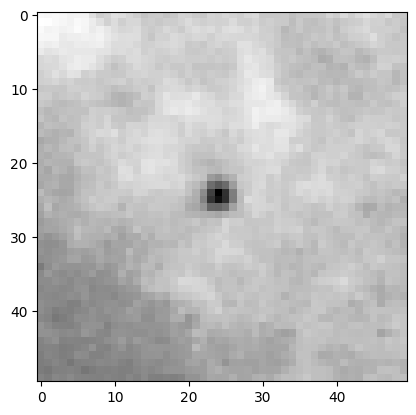

In [691]:
cutouts = get_cutouts(400)

# Separate images and labels
images = [item[0] for item in cutouts]
labels = [item[1] for item in cutouts]

log_normalized_images = []
for img in images:
    img = img.astype(np.float32) 
    norm = LogNorm()
    normalized_img = norm(img) 
    
    normalized_img = (normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min()) * 255
    normalized_img = np.clip(normalized_img, 0, 255).astype(np.uint8)
    log_normalized_images.append(normalized_img)

pil_images = [Image.fromarray(img) for img in log_normalized_images]
plt.imshow(pil_images[0], cmap='Greys')
plt.show()


In [692]:
# Sets computation device to whatever is available (likely CPU in this case)
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")

# Specifices version of CLIP to be used from huggingface 
model_id = "openAI/clip-vit-base-patch32"

# Loads the model, tokenizer, and processor
model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)


In [693]:
# Sets input prompt and tokenizes it using tokenizer

prompt_one = "globular cluster, central peak, symmetrical, slighlty more extended than point source"
prompt_two = "open cluster, central peak, asymmetrical or elongated, slightly more extended"
prompt_three = "compact stellar association, asymmetric, multiple peaks, dispersed"
prompt_four = "irregular, asymmetrical, uncircular, multiple peakes, oblong"

inputs_one = tokenizer(prompt_one, return_tensors="pt")
inputs_two = tokenizer(prompt_two, return_tensors="pt")
inputs_three = tokenizer(prompt_three, return_tensors="pt")
inputs_four = tokenizer(prompt_four, return_tensors="pt")

In [694]:
# Embeds the prompt into a vector space in shape suitable for the model
text_emb_one = model.get_text_features(**inputs_one)
text_emb_two = model.get_text_features(**inputs_two)
text_emb_three = model.get_text_features(**inputs_three)
text_emb_four = model.get_text_features(**inputs_four)

In [695]:
# Processor is used for image and text processing, however this instance is only for images and returns it as a tensor.
image = processor(
    text=None,
    images=pil_images[0], #Custom cluster dataset
    # images=dataset[0]['image'], #Imagenette dataset 
    return_tensors="pt",
    do_rescale=False
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [696]:
image.squeeze(0).T.shape


torch.Size([224, 224, 3])

In [697]:
print(f"Min: {image.min()}, Max: {image.max()}")

Min: -1.7922625541687012, Max: 974.1279907226562


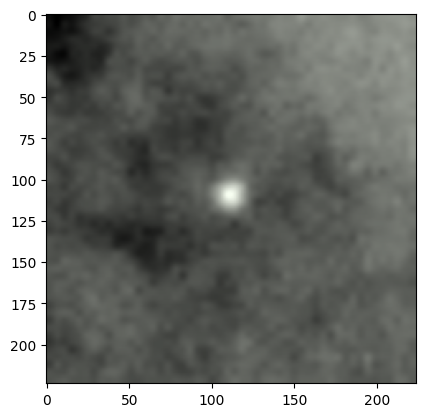

torch.Size([224, 224, 3])

In [698]:
def normalize_tensor(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    normalized_tensor = (tensor - min_val) / (max_val - min_val)
    return normalized_tensor

normalized_tensor = normalize_tensor(image.squeeze(0).T) #Normalize the tensor.
plt.imshow(normalized_tensor.cpu().numpy()) #Display the normalized tensor.
plt.show()
normalized_tensor.shape

In [699]:
# Embeds image into vector space, similar to text embedding 
image_emb = model.get_image_features(normalized_tensor.T.unsqueeze(0))
image_emb.shape

torch.Size([1, 512])

In [700]:
from tqdm.auto import tqdm

batch_size = 10 # change depending on size of test set
image_arr = None

for i in tqdm(range(0, len(pil_images), batch_size)):
    # select batch of images
    batch = pil_images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    #conver to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    #add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape



  0%|          | 0/40 [00:00<?, ?it/s]

(400, 512)

In [701]:
image_arr.min(), image_arr.max() 

(np.float32(-9.536295), np.float32(2.4201262))

In [702]:
# Normalizes the image embeddings
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)

In [703]:
image_arr = image_arr.T
image_arr.shape
image_arr.min(), image_arr.max()

(np.float32(-0.7999526), np.float32(0.2224071))

In [704]:
text_emb_one = text_emb_one.cpu().detach().numpy()
text_emb_two = text_emb_two.cpu().detach().numpy()
text_emb_three = text_emb_three.cpu().detach().numpy()
text_emb_four = text_emb_four.cpu().detach().numpy()

In [705]:
# Takes the dot product of each image and the prompt to determine similarities scores
scores_one = np.dot(text_emb_one, image_arr.T)
scores_two = np.dot(text_emb_two, image_arr.T)
scores_three = np.dot(text_emb_three, image_arr.T)
scores_four = np.dot(text_emb_four, image_arr.T)

In [706]:
# Takes the top 5 image scores for prompt 1 and stores them in an index array
top_k = 400
idx_one = np.argsort(-scores_one[0])[:top_k]

2.4880824


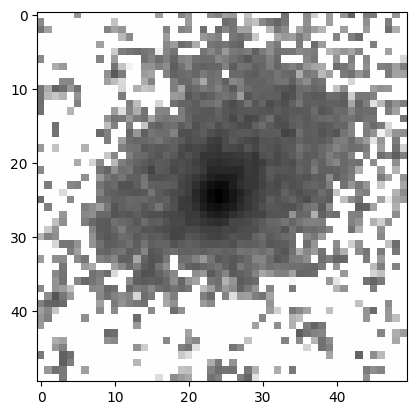

class4


In [707]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_one[0][idx_one[i]])
    plt.imshow(pil_images[idx_one[i]], cmap='Greys')
    plt.show()
    print(labels[idx_one[i]])

In [708]:
# Takes the top 5 image scores for prompt 2 and stores them in an index array
idx_two = np.argsort(-scores_two[0])[:top_k]

2.3689349


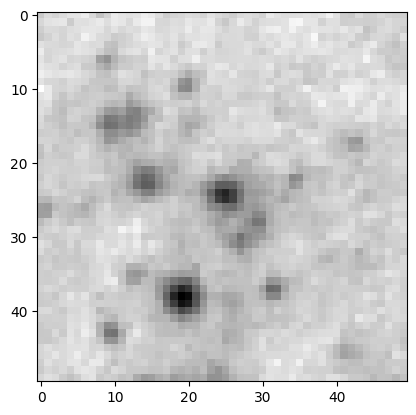

class4


In [709]:
# Prints the 5 images with the highest scores
for i in range(1):
    print(scores_two[0][idx_two[i]])
    plt.imshow(pil_images[idx_two[i]], cmap='Greys')
    plt.show()
    print(labels[idx_two[i]])

In [710]:
# Takes the top 5 image scores for prompt 3 and stores them in an index array
idx_three = np.argsort(-scores_three[0])[:top_k]

2.9192078


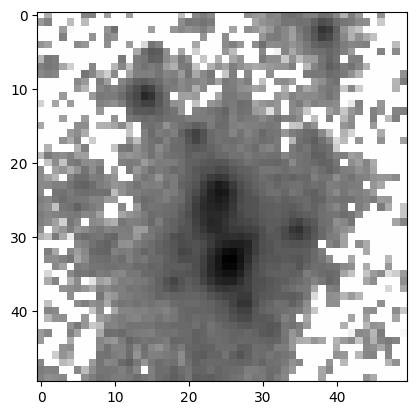

class3


In [711]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_three[0][idx_three[i]])
    plt.imshow(pil_images[idx_three[i]], cmap='Greys')
    plt.show()
    print(labels[idx_three[i]])


In [712]:
# Takes the top 5 image scores for prompt 3 and stores them in an index array
idx_four = np.argsort(-scores_four[0])[:top_k]

2.478339


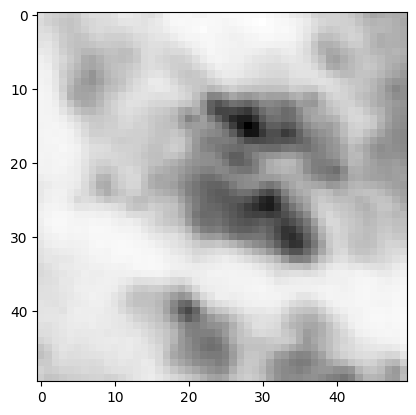

class4


In [713]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_four[0][idx_four[i]])
    plt.imshow(pil_images[idx_four[i]], cmap='Greys')
    plt.show()
    print(labels[idx_four[i]])


In [714]:
# Finds earliest occurence of each image in score indexes and assigns them to respective category
# Convert lists to dictionaries for O(1) lookups
pos_one = {img: i for i, img in enumerate(idx_one)}
pos_two = {img: i for i, img in enumerate(idx_two)}
pos_three = {img: i for i, img in enumerate(idx_three)}
pos_four = {img: i for i, img in enumerate(idx_four)}

cat_one = []
cat_two = []
cat_three = []
cat_four = []

# Get unique images from all three lists
all_images = set(idx_one) | set(idx_two) | set(idx_three) | set(idx_four)

for img in all_images:
    # Get positions, using a large default if missing
    pos1 = pos_one.get(img, float('inf'))
    pos2 = pos_two.get(img, float('inf'))
    pos3 = pos_three.get(img, float('inf'))
    pos4 = pos_four.get(img, float('inf'))

    # Determine which list contains the earliest occurrence
    min_pos = min(pos1, pos2, pos3, pos4)

    if min_pos == pos1:
        cat_one.append(img)
    elif min_pos == pos2:
        cat_two.append(img)
    elif min_pos == pos3:
        cat_three.append(img)
    elif min_pos == pos4:
        cat_four.append(img)

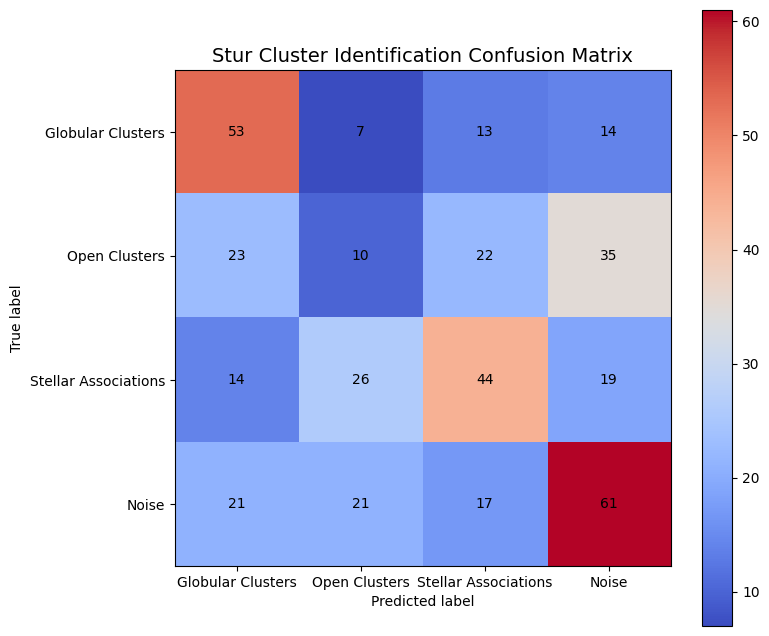

In [715]:
actual = []
predicted = []

for i in cat_one:
    actual.append(labels[i])  # Map class2 to class1 in actual
    predicted.append("class1")  # Predict class1 for cat_one

for i in cat_two:
    actual.append(labels[i])
    predicted.append("class2")  # Predict class3 for cat_two

for i in cat_three:
    actual.append(labels[i])
    predicted.append("class3")  # Predict class4 for cat_three

for i in cat_four:
    actual.append(labels[i])
    predicted.append("class4")  # Predict class3 for cat_two

actual = np.array(actual)
predicted = np.array(predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=["class1", "class2", "class3", "class4"])

category_labels = ["Globular Clusters", "Open Clusters", "Stellar Associations", "Noise"]

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=category_labels)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display.plot(cmap="coolwarm", ax=ax, values_format="d")

for text in ax.texts:
    text.set_color("black")

plt.title("Stur Cluster Identification Confusion Matrix", fontsize=14)
plt.show()

In [716]:
def precision(class_type, id):
    
    true_positive = 0
    false_positive = 0

    for i in class_type:
        if labels[i] == id:
            true_positive += 1
        else:
            false_positive += 1
        
    prec_val = (true_positive / (true_positive+false_positive)) * 100

    return prec_val

In [717]:
def recall(class_type, id):
    
    count = 0
    true_positive = 0
    false_negative = 0

    for i in labels:
        if i == id:
            count += 1

    for i in class_type:
        if labels[i] == id:
            true_positive += 1

    false_negative = count - true_positive

    recall_val = (true_positive / (true_positive+false_negative)) * 100

    return recall_val

In [718]:
def f_one_score(precision_val, recall_val):
    f_one = (2*precision_val*recall_val)/(precision_val+recall_val)
    return f_one

In [719]:
def accuracy():

    correct = 0
    total = 0

    for i in labels:
        total += 1

    for i in cat_one:
        if labels[i] == "class1":
            correct += 1
    
    for i in cat_two:
        if labels[i] == "class2":
            correct += 1
    
    for i in cat_three:
        if labels[i] == "class3":
            correct += 1
    
    for i in cat_four:
        if labels[i] == "class4":
            correct += 1
    
    acc = (correct / total) * 100
    return acc


In [720]:
def calculate_and_store_metrics():
    results = {
        "Class 1": {
            "Precision": round(precision(cat_one, "class1"), 2),
            "Recall": round(recall(cat_one, "class1"), 2),
            "F1 Score": round(f_one_score(precision(cat_one, "class1"), recall(cat_one, "class1")), 2),
        },
        "Class 2": {
            "Precision": round(precision(cat_two, "class2"), 2),
            "Recall": round(recall(cat_two, "class2"), 2),
            "F1 Score": round(f_one_score(precision(cat_two, "class2"), recall(cat_two, "class2")), 2),
        },
        "Class 3": {
            "Precision": round(precision(cat_three, "class3"), 2),
            "Recall": round(recall(cat_three, "class3"), 2),
            "F1 Score": round(f_one_score(precision(cat_three, "class3"), recall(cat_three, "class3")), 2),
        },
        "Class 4": {
            "Precision": round(precision(cat_four, "class4"), 2),
            "Recall": round(recall(cat_four, "class4"), 2),
            "F1 Score": round(f_one_score(precision(cat_four, "class4"), recall(cat_four, "class4")), 2),
        },
        "Overall Accuracy": round(accuracy(), 2),
    }

    filepath = "../data/evaluation_metrics.json"
    if os.path.exists(filepath):
        with open(filepath, "r") as f:
            try:
                all_results = json.load(f)
                if not isinstance(all_results, list) or not all_results:
                    all_results = [{}]
            except json.JSONDecodeError:
                all_results = [{}]
    else:
        all_results = [{}]

    existing_metrics = all_results[0]

    for class_name, metrics in results.items():
        if class_name == "Overall Accuracy":
            if class_name in existing_metrics:
                existing_metrics[class_name] = str(existing_metrics[class_name]) + ", " + str(metrics)
            else:
                existing_metrics[class_name] = metrics
        elif class_name in existing_metrics:
            for metric_name, metric_value in metrics.items():
                existing_metrics[class_name][metric_name] = str(existing_metrics[class_name][metric_name]) + ", " + str(metric_value)
        else:
            existing_metrics[class_name] = metrics

    with open(filepath, "w") as f:
        json.dump(all_results, f, indent=4)

calculate_and_store_metrics()